## Altered pipeline using cross_validate and base classifiers (no hyperparemeters or search)

### Importing

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
from os import path as op
from pathlib import Path
import yaml
from yaml import CLoader as Loader
from glob import glob
import matplotlib.pyplot as plt
import scipy.stats as ss
# MNE
import mne
from mne_bids import write_raw_bids, BIDSPath, update_sidecar_json
from mne_bids.stats import count_events
from mne import io, EvokedArray
from mne.decoding import Vectorizer, get_coef, LinearModel
# Scikit-learn
from sklearn.utils.fixes import loguniform
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report, make_scorer, balanced_accuracy_score, fbeta_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix
    # Classifiers
from sklearn import svm
from sklearn.svm import LinearSVC    
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


mne.set_log_level(verbose='Warning')

In [8]:
conditions = ['Neutral/Upright/Faces/Target','Neutral/Upright/Faces/Standard',
              'Neutral/Upright/Silhouettes/Target','Neutral/Upright/Silhouettes/Standard',
              
              'Green/Upright/Faces/Target','Green/Upright/Faces/Standard',
              'Green/Upright/Silhouettes/Target','Green/Upright/Silhouettes/Standard',
              
              'Neutral/Inverted/Faces/Target','Neutral/Inverted/Faces/Standard',
              'Neutral/Inverted/Silhouettes/Target','Neutral/Inverted/Silhouettes/Standard',
              
              'Green/Inverted/Faces/Target','Green/Inverted/Faces/Standard',
              'Green/Inverted/Silhouettes/Target','Green/Inverted/Silhouettes/Standard',
              
              'Target', 'Standard'
             ]

coi = ['Target', 'Standard']

contrasts = {'Neutral/Upright/Faces':['Neutral/Upright/Faces/Target','Neutral/Upright/Faces/Standard'],
             'Neutral/Upright/Silhouettes':['Neutral/Upright/Silhouettes/Target','Neutral/Upright/Silhouettes/Standard'],
             
             'Green/Upright/Faces':['Green/Upright/Faces/Target','Green/Upright/Faces/Standard'],
             'Green/Upright/Silhouettes':['Green/Upright/Silhouettes/Target','Green/Upright/Silhouettes/Standard'],
             
             'Neutral/Inverted/Faces':['Neutral/Inverted/Faces/Target','Neutral/Inverted/Faces/Standard'],
             'Neutral/Inverted/Silhouettes':['Neutral/Inverted/Silhouettes/Target','Neutral/Inverted/Silhouettes/Standard'],
             
             'Green/Inverted/Faces':['Green/Inverted/Faces/Target','Green/Inverted/Faces/Standard'],
             'Green/Inverted/Silhouettes':['Green/Inverted/Silhouettes/Target','Green/Inverted/Silhouettes/Standard'],
             
             'Target-Nontarget':['Target', 'Standard']
            }


### Yaml + Pathing

In [9]:
## YAML
bids_root = '../..'

cfg_file = op.join(bids_root, 'config.yml')
with open(cfg_file, 'r') as f:
    config = yaml.load(f, Loader=Loader)

study_name = config['study_name']
task = config['task']
data_type = config['data_type']
eog = config['eog']
montage_fname = config['montage_fname']
n_jobs = 22

epoch_p =  {k: v for d in config['preprocessing_settings']['epoch'] for k, v in d.items()}

cl_p = {k: v for d in config['classification'] for k, v in d.items()}

## Pathing
source_path = op.join(bids_root, 'derivatives', 'erp_preprocessing')

derivatives_path = op.join(bids_root, 'derivatives', 'erp_classification_test_' + str(cl_p['test_size'])[-1] + '0_pct')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

out_path = op.join(derivatives_path, 'data')
if Path(out_path).exists() == False:
    Path(out_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'reports')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)

fig_path = op.join(derivatives_path, 'figures')
if Path(fig_path).exists() == False:
    Path(fig_path).mkdir(parents=True) 

tab_path = op.join(derivatives_path, 'tables')
if Path(tab_path).exists() == False:
    Path(tab_path).mkdir(parents=True) 
    
epochs_suffix = '-epo.fif'

## Output files
out_file = op.join(tab_path, 'classification_overall_results.csv')
summary_file =  op.join(tab_path, 'classification_accuracy_summary.csv')
plot_stem = op.join(fig_path, 'plot_')
fig_format = 'pdf'

### Instantiating classifiers, parameter grids, and scoring metrics.

In [10]:
scaler = StandardScaler()
vectorizer = Vectorizer()

svm = LinearSVC(random_state=42, max_iter=5000, dual=True)
lda = LinearDiscriminantAnalysis()
rf = RandomForestClassifier(random_state=42, n_jobs=10)


classifiers = {'SVM': svm,
               'LDA': lda,
               'RF': rf
              }

## SCORING
scoring = {'Prec': make_scorer(precision_score, zero_division=0),
           'Bal_Acc': make_scorer(balanced_accuracy_score),
           'Acc': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'ROC': make_scorer(roc_auc_score),
           'Matthews_Coef': make_scorer(matthews_corrcoef),
           'Fbeta_0.5': make_scorer(fbeta_score, beta = 0.5),
           'Fbeta_1.5': make_scorer(fbeta_score, beta = 1.5),
           'F1_score': make_scorer(f1_score, zero_division=0)
          }


### Subjects + Loading em' in

In [11]:
## For Running ALL data in batch
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(source_path + '/' + prefix + '*')])
print("n subjects = ", len(subjects))

## For Running Individual participants
# subjects = ['sub-002'] #, 'sub-032'
# print("n subjects = ", len(subjects))

## Reading in data
epochs = {}
print('Loading Subjects:', subjects)
for subject in subjects:
    raw_path = op.join(bids_root, 'derivatives', 'erp_preprocessing', subject, 'eeg')
    raw_subj = glob(op.join(raw_path + '/' + '*-epo.fif'))
    
    
    epochs[subject] = mne.read_epochs(raw_subj.pop(), proj=False, verbose=False, preload=True)

    
    # Correcting for presentation delay
    epochs[subject]._raw_times = epochs[subject]._raw_times - epoch_p['tshift']
    epochs[subject]._times_readonly = epochs[subject]._times_readonly - epoch_p['tshift']


n subjects =  31
Loading Subjects: ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032']


<ipython-input-11-46c7b41fabd5>:16: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs[subject] = mne.read_epochs(raw_subj.pop(), proj=False, verbose=False, preload=True)
<ipython-input-11-46c7b41fabd5>:16: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs[subject] = mne.read_epochs(raw_subj.pop(), proj=False, verbose=False, preload=True)
<ipython-input-11-46c7b41fabd5>:16: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs[subject] = mne.read_epochs(raw_subj.pop(), proj=False, verbose=False, preload=True)
<ipython-input-11-46c7b41fabd5>:16: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs[subject] = mne.read_epochs(raw_subj.pop(), proj=False, verbose=False, preload=True)
<ipython-input-11-46c7b41fabd5>:16: RuntimeWarning: The events passed to the Epochs constructor are not chronolo

In [24]:
epochdf = pd.DataFrame()
epochlist = []

for subject in subjects:

    raw_path = op.join(bids_root, 'derivatives', 'erp_preprocessing', subject, 'eeg')
    
    raw_subj = glob(op.join(raw_path + '/' + '*-epo.fif'))
    
    epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
    num_epochs = len(epochs)

    print(f'Subject {subject} has: {num_epochs}')
    
    epochlist.append(pd.DataFrame({'subject':subject,
                                   '# epochs':num_epochs}, index=[0]))
    
epochdf = pd.concat(epochlist)
epochdf.to_csv('participant_epoch_data.csv')

<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-001 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-002 has: 1457


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-003 has: 1349


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-004 has: 1454


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-005 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-006 has: 1469


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-007 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-008 has: 1483


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-009 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-010 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-011 has: 1448


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-012 has: 1477


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-013 has: 1487


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-014 has: 1478


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-015 has: 1459


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-016 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-017 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-018 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-019 has: 1423


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-020 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-021 has: 1410


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-022 has: 1472


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-023 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-025 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-026 has: 1480


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-027 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-028 has: 1403


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-029 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-030 has: 1488


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


Subject sub-031 has: 1488
Subject sub-032 has: 1484


<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)
<ipython-input-24-2fd38ca0c70c>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(raw_subj.pop(), proj=False, preload=True)


### Batch Loop

Exception reporting mode: Verbose

-------
sub-002
-------
Neutral/Upright/Faces
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        30
           1       0.25      1.00      0.40         6

    accuracy                           0.50        36
   macro avg       0.62      0.70      0.49        36
weighted avg       0.88      0.50      0.54        36



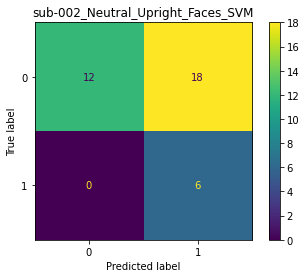

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.25      0.17      0.20         6

    accuracy                           0.78        36
   macro avg       0.55      0.53      0.54        36
weighted avg       0.74      0.78      0.76        36



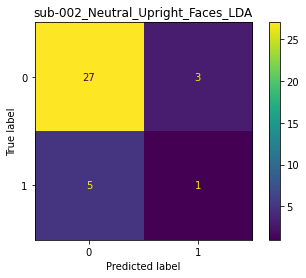

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       1.00      0.17      0.29         6

    accuracy                           0.86        36
   macro avg       0.93      0.58      0.60        36
weighted avg       0.88      0.86      0.82        36



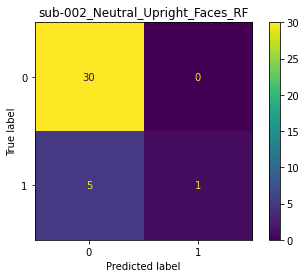

-------
Neutral/Upright/Silhouettes
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.88      0.50      0.64        30
           1       0.21      0.67      0.32         6

    accuracy                           0.53        36
   macro avg       0.55      0.58      0.48        36
weighted avg       0.77      0.53      0.59        36



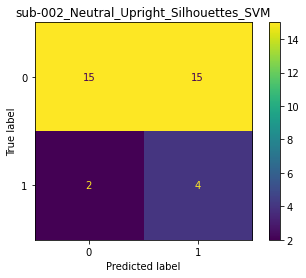

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.33      0.33      0.33         6

    accuracy                           0.78        36
   macro avg       0.60      0.60      0.60        36
weighted avg       0.78      0.78      0.78        36



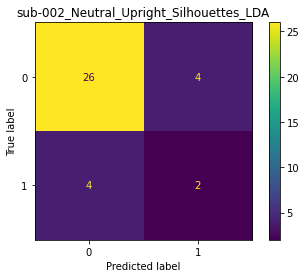

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       0.00      0.00      0.00         6

    accuracy                           0.83        36
   macro avg       0.42      0.50      0.45        36
weighted avg       0.69      0.83      0.76        36



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


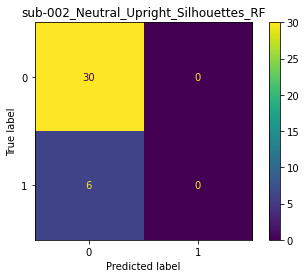

-------
Green/Upright/Faces
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.33      0.67      0.44         6

    accuracy                           0.72        36
   macro avg       0.62      0.70      0.63        36
weighted avg       0.82      0.72      0.75        36



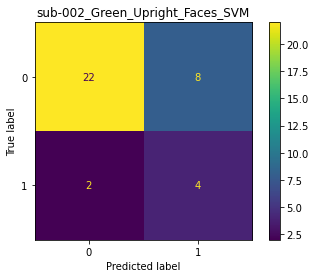

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.75      0.50      0.60         6

    accuracy                           0.89        36
   macro avg       0.83      0.73      0.77        36
weighted avg       0.88      0.89      0.88        36



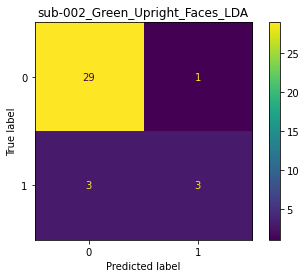

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       1.00      0.33      0.50         6

    accuracy                           0.89        36
   macro avg       0.94      0.67      0.72        36
weighted avg       0.90      0.89      0.86        36



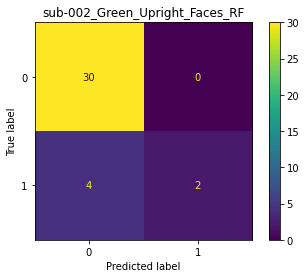

-------
Green/Upright/Silhouettes
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.85      0.68      0.76        25
           1       0.20      0.40      0.27         5

    accuracy                           0.63        30
   macro avg       0.53      0.54      0.51        30
weighted avg       0.74      0.63      0.67        30



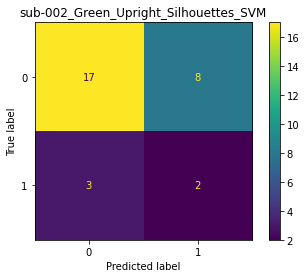

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       0.00      0.00      0.00         5

    accuracy                           0.83        30
   macro avg       0.42      0.50      0.45        30
weighted avg       0.69      0.83      0.76        30



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


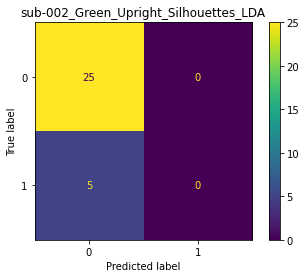

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       0.00      0.00      0.00         5

    accuracy                           0.83        30
   macro avg       0.42      0.50      0.45        30
weighted avg       0.69      0.83      0.76        30



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


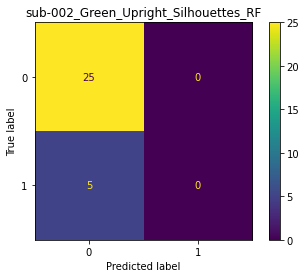

-------
Neutral/Inverted/Faces
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        30
           1       0.28      0.83      0.42         6

    accuracy                           0.61        36
   macro avg       0.61      0.70      0.56        36
weighted avg       0.83      0.61      0.66        36



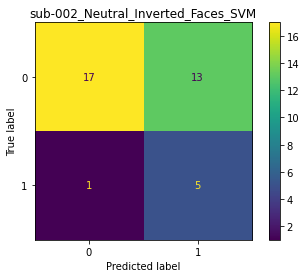

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.40      0.33      0.36         6

    accuracy                           0.81        36
   macro avg       0.64      0.62      0.62        36
weighted avg       0.79      0.81      0.80        36



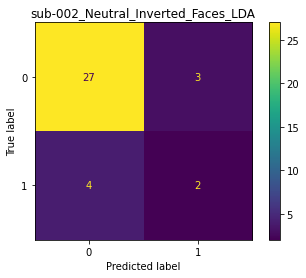

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       1.00      0.17      0.29         6

    accuracy                           0.86        36
   macro avg       0.93      0.58      0.60        36
weighted avg       0.88      0.86      0.82        36



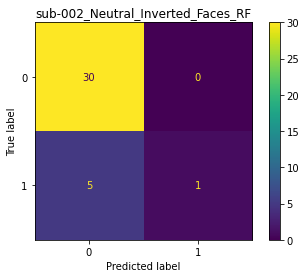

-------
Neutral/Inverted/Silhouettes
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       1.00      0.57      0.72        30
           1       0.32      1.00      0.48         6

    accuracy                           0.64        36
   macro avg       0.66      0.78      0.60        36
weighted avg       0.89      0.64      0.68        36



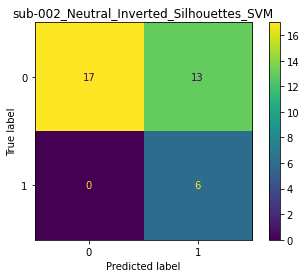

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.50      0.33      0.40         6

    accuracy                           0.83        36
   macro avg       0.69      0.63      0.65        36
weighted avg       0.81      0.83      0.82        36



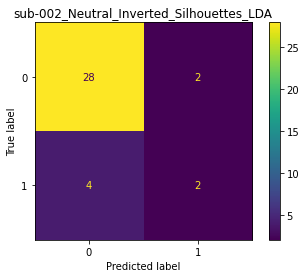

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       0.00      0.00      0.00         6

    accuracy                           0.83        36
   macro avg       0.42      0.50      0.45        36
weighted avg       0.69      0.83      0.76        36



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


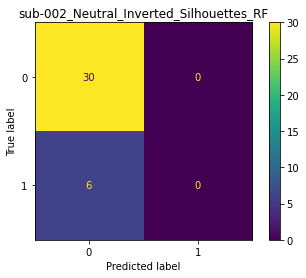

-------
Green/Inverted/Faces
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.91      0.70      0.79        30
           1       0.31      0.67      0.42         6

    accuracy                           0.69        36
   macro avg       0.61      0.68      0.61        36
weighted avg       0.81      0.69      0.73        36



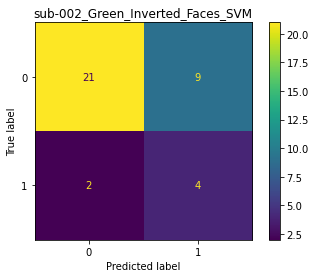

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.50      0.17      0.25         6

    accuracy                           0.83        36
   macro avg       0.68      0.57      0.58        36
weighted avg       0.79      0.83      0.80        36



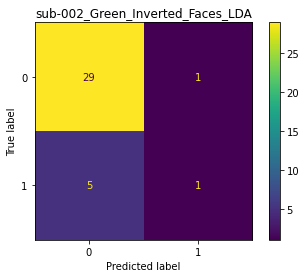

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       0.00      0.00      0.00         6

    accuracy                           0.83        36
   macro avg       0.42      0.50      0.45        36
weighted avg       0.69      0.83      0.76        36



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


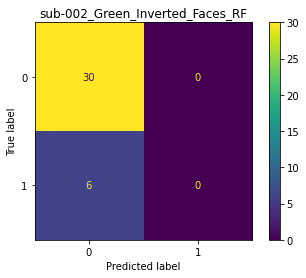

-------
Green/Inverted/Silhouettes
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.89      0.57      0.69        30
           1       0.24      0.67      0.35         6

    accuracy                           0.58        36
   macro avg       0.57      0.62      0.52        36
weighted avg       0.78      0.58      0.64        36



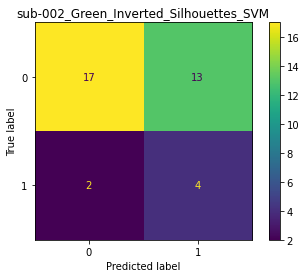

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.50      0.17      0.25         6

    accuracy                           0.83        36
   macro avg       0.68      0.57      0.58        36
weighted avg       0.79      0.83      0.80        36



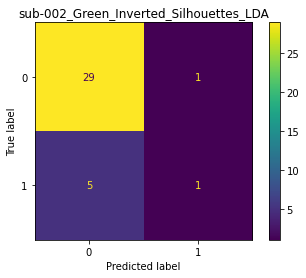

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       0.00      0.00      0.00         6

    accuracy                           0.83        36
   macro avg       0.42      0.50      0.45        36
weighted avg       0.69      0.83      0.76        36



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


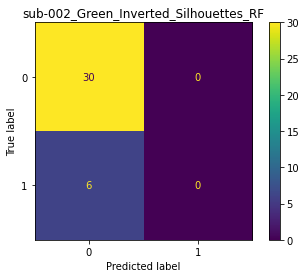

-------
Target-Nontarget
-------
Running classifier: SVM
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       235
           1       0.35      0.62      0.45        47

    accuracy                           0.75       282
   macro avg       0.63      0.70      0.64       282
weighted avg       0.82      0.75      0.77       282



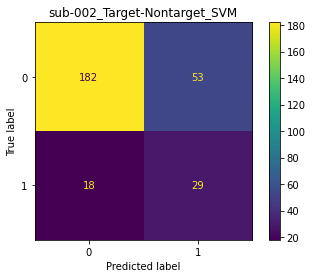

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       235
           1       0.35      0.62      0.45        47

    accuracy                           0.74       282
   macro avg       0.63      0.69      0.64       282
weighted avg       0.82      0.74      0.77       282



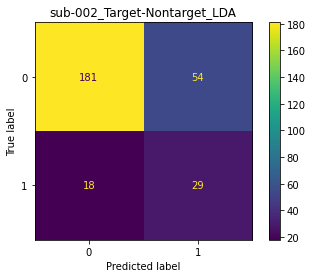

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       235
           1       0.33      0.02      0.04        47

    accuracy                           0.83       282
   macro avg       0.58      0.51      0.47       282
weighted avg       0.75      0.83      0.76       282



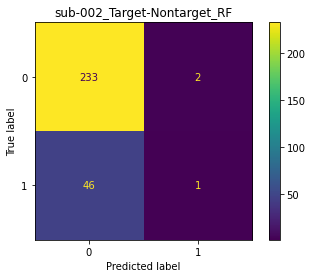

CPU times: user 3min 45s, sys: 1min 58s, total: 5min 44s
Wall time: 4min 23s


In [6]:
%%time
%xmode Verbose

# Making the crossvalidation to be used in the RandomizedSearch
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for subject in subjects:
    print('\n-------\n\033[;40m' + subject + '\033[m')
    
    # Clearing out the saved data for each participant
    data_table = pd.DataFrame()
    data_table_list = []
    
    for contr, conds in contrasts.items():
        print('-------\n\033[94;40m' + contr + '\033[m')
        subj_epochs = epochs[subject][conds]
        
        # Create a list of labels from event codes mapped to event_id
        event_id_rev = dict(zip(subj_epochs.event_id.values(), subj_epochs.event_id.keys()))
        labels_all = [event_id_rev[e] for e in subj_epochs.events[:, 2]]
        labels_all = pd.DataFrame(labels_all)[0].str.split('/', expand=True).rename(columns={0:'Colour', 1:'Orientation', 2:'Type', 3:'Status', 4:'Location'} )
        label_map = {'Target':1, 'Standard':0}
        labels_all['labels'] = labels_all['Status'].map(label_map)
        labels = labels_all['labels']
        
        # Extract data from subj_epochs and vectorize 
        D = subj_epochs.get_data()
        
        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(D, 
                                                            labels,
                                                            stratify=labels,
                                                            test_size=cl_p['test_size'], 
                                                            random_state=42,
                                                            shuffle=True
                                                           )

        # Classifier Loop
        for c_name, c in classifiers.items():
            print('-------\nRunning classifier: \033[1;91;40m' + c_name + '\033[m')

            # Making the Pipeline
            clf = Pipeline([('Vectorizer', vectorizer),
                             ('Scaler', scaler),
                             (c_name, c)                                 
                             ])

            # Cross validating
            cv_cv = cross_validate(clf, X_train, y_train, 
                                   cv=cv,
                                   scoring=scoring,
                                   return_train_score=True, # Determines if Training scores are included in .cv_results_
                                   n_jobs=5,
                                   error_score='raise' # For debugging purposes
                                   )

            print('Training Classifier')
            clf = clf.fit(X_train, y_train)

            print('Predicting...')
            y_pred = clf.predict(X_test)

            print('Scoring...')        
            print(classification_report(y_test, y_pred))

            # Confusion Matrix Generation and Visualization within the loop -> saved to csv as "[[TN, FN] [FP, TP]]"
            cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
            cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
            cmd.plot()
            plt.title(subject + '_' + str(contr).replace('/', '_') + '_' + c_name)
            plt.show()

            # Saving CV results to a DataFrame 
            results = pd.DataFrame(cv_cv)

            data_table_list.append(pd.DataFrame({'participant_id': subject,
                                              'Condition': contr,
                                              'Classifier': c_name,

                                              # Confusion_matrix saved in format: [[TN, FN] [FP, TP]]
                                              'Confusion_Matrix': str(cm),                                                 

                                              'CV_Train_Bal_Accuracy': results['train_Bal_Acc'].round(3) * 100,
                                              'CV_Test_Bal_Accuracy': results['test_Bal_Acc'].round(3) * 100,
                                              'Test_Bal_Accuracy': round(balanced_accuracy_score(y_test, y_pred), 3) * 100,

                                              'CV_Train_Accuracy': results['train_Acc'].round(3) * 100,
                                              'CV_Test_Accuracy': results['test_Acc'].round(3) * 100,
                                              'Test_Accuracy': round(accuracy_score(y_test, y_pred), 3) * 100, 

                                              'CV_Train_Precision': results['train_Prec'].round(3) * 100,
                                              'CV_Test_Precision': results['test_Prec'].round(3) * 100,                                                
                                              'Test_Precision': round(precision_score(y_test, y_pred, zero_division=0), 3) * 100,    

                                              'CV_Train_Matthews_coef': results['train_Matthews_Coef'].round(3),
                                              'CV_Test_Matthews_coef': results['test_Matthews_Coef'].round(3),
                                              'Matthews_Coef': round(matthews_corrcoef(y_test, y_pred), 3),

                                              'CV_Train_Recall': results['train_Recall'].round(3) * 100,
                                              'CV_Test_Recall': results['test_Recall'].round(3) * 100,
                                              'Test_recall': round(recall_score(y_test, y_pred), 3) * 100,

                                              'CV_Train_Fbeta_0.5': results['train_Fbeta_0.5'].round(3),
                                              'CV_Train_Fbeta_0.5': results['train_Fbeta_0.5'].round(3),
                                              'Fbeta_0.5': round(fbeta_score(y_test, y_pred, beta = 0.5, zero_division=0), 3),

                                              'CV_Train_Fbeta_1.5': results['train_Fbeta_1.5'].round(3),
                                              'CV_Test_Fbeta_1.5': results['test_Fbeta_1.5'].round(3),
                                              'Fbeta_1.5': round(fbeta_score(y_test, y_pred, beta = 1.5, zero_division=0), 3),

                                              'CV_Train_F1': results['train_F1_score'].round(3),
                                              'CV_Test_F1': results['test_F1_score'].round(3),
                                              'F1_score': round(f1_score(y_test, y_pred, zero_division=0), 3),

                                              'CV_Train_ROC_AUC': results['train_ROC'].round(3),
                                              'CV_Test_ROC_AUC': results['test_ROC'].round(3),                                             
                                              'Test_ROC_AUC': round(roc_auc_score(y_test, y_pred), 3),

                                              'Mean Fit Time': results['fit_time'].round(3),
                                              'Mean Score Time': results['score_time'].round(3)
                                             }, index=[0]
                                            )
                               )

    # Saving Data to CSV Per Participant
    data_table = pd.concat(data_table_list)
    data_table.to_csv(f'{str(subject)} new_Data.csv')